copy from https://colab.research.google.com/drive/1c2qk92NhjRQt8oQmQZcFqtBzJUP6kXLR

## Fetch title judgments dataset.

this is a set of training data logged alongside some simple relevance features (title and overview Elasticsearch BM25) used to predict relevance. Of course we're pretty limitted because of these features, but this is more about the toy example :)

### What's in this dataframe?

* **qid** - the unique identifier of the query (ie `rambo`). Here it maps to a query keywords, but `qid` could mean any query entity for our domain, a user, a user+keyword, keyword+location - whatever makes sense!
* **keywords** - the search terms corresponding to the `qid`
* **docId** - the document being graded. A movie in [TheMovieDB](http://themoviedb.org)
* **grade** - how relevant the document is for the query (0 least relevant, 4 most relevant). This is kind of the label of learning to rank datasets
* **features** - a feature vector that will be used to predict relevance 


In [2]:
import requests
from io import BytesIO
import pandas as pd


pkl_file = requests.get("http://softwaredoug.com/data/title_judgments_logged.json.gz")
judgments = pd.read_json(BytesIO(pkl_file.content), compression='gzip')
judgments

,uid,qid,keywords,docId,grade,features
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]"
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]"
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]"
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]"
4,11368,1,rambo,1368,4,"[0.0, 11.113943]"
...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]"
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]"
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]"
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]"


## Reinitialize training set for this round of training

Each round we attempt to learn the errors of the previous round. We start the first round with the judgments themselves, and initialize the prediction of the models thus far to 0.0. 

We sort by the current prediction on each round before the [LambdaMART pairwise swapping procedure](https://softwaredoug.com/blog/2021/11/28/how-lammbamart-works.html).



In [3]:
lambdas_per_query = judgments.copy()


lambdas_per_query['last_prediction'] = 0.0
lambdas_per_query.sort_values(['qid', 'last_prediction'], ascending=[True, False], kind='stable')

,uid,qid,keywords,docId,grade,features,last_prediction
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",0.0
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",0.0
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",0.0
3,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",0.0
4,11368,1,rambo,1368,4,"[0.0, 11.113943]",0.0
...,...,...,...,...,...,...,...
1385,4037079,40,star wars,37079,0,"[0.0, 0.0]",0.0
1386,40126757,40,star wars,126757,0,"[0.0, 0.0]",0.0
1387,4039797,40,star wars,39797,0,"[0.0, 0.0]",0.0
1388,4018112,40,star wars,18112,0,"[0.0, 0.0]",0.0


## Compute DCG stats 

To prep for pairwise swapping using DCG as a statistic - compute DCG stats relative to the `last_prediction` ranking. This includes:

* `display_rank` - where the result ranks when ordered by `last_prediction`
* `discount` - the weight given to this display position. Positions higher up on the page / lower `display_rank`s are weighed as more important.
* `gain` - the weight of a given label/grade. 2^grade - 1.

In [4]:
import numpy as np

lambdas_per_query.sort_values(['qid', 'last_prediction'], ascending=[True, False], kind='stable')
lambdas_per_query['display_rank'] = lambdas_per_query.groupby('qid').cumcount()

#TBD - How do generalize this?
lambdas_per_query['discount'] = 1 / np.log2(2 + lambdas_per_query['display_rank'])
lambdas_per_query['gain'] = (2**lambdas_per_query['grade'] - 1)

lambdas_per_query[['qid', 'display_rank', 'discount', 'grade', 'gain']]

,qid,display_rank,discount,grade,gain
0,1,0,1.000000,4,15
1,1,1,0.630930,3,7
2,1,2,0.500000,3,7
3,1,3,0.430677,2,3
4,1,4,0.386853,4,15
...,...,...,...,...,...
1385,40,25,0.210310,0,0
1386,40,26,0.208015,0,0
1387,40,27,0.205847,0,0
1388,40,28,0.203795,0,0


## Map each result to every other result

Per query, we must line up each result with every other result of that query. We do that with an outer join of every row for a query to every other row for that query

In [5]:
import numpy as np

# each group paired with each other group
swaps = lambdas_per_query.merge(lambdas_per_query, on='qid', how='outer')
# changes[j][i] = changes[i][j] = (discount(i) - discount(j)) * (gain(rel[i]) - gain(rel[j]));
swaps['delta'] = np.abs((swaps['discount_x'] - swaps['discount_y']) * (swaps['gain_x'] - swaps['gain_y']))
swaps[['qid', 'display_rank_x', 'display_rank_y', 'delta']]

,qid,display_rank_x,display_rank_y,delta
0,1,0,0,0.000000
1,1,0,1,2.952562
2,1,0,2,4.000000
3,1,0,3,6.831881
4,1,0,4,0.000000
...,...,...,...,...
49019,40,29,25,0.000000
49020,40,29,26,0.000000
49021,40,29,27,0.000000
49022,40,29,28,0.000000


## Rho - weight of each swap in proportion to its error

We compute a value called `rho` which tells us how much this round should learn this swap as a function for how different the `last_prediction` delta is from the `dcg` delta. 

Starting off, we essentially just learn `delta` given the `last_predictions` are all 0.0

In [6]:
swaps['rho'] = 1 / (1 + np.exp(swaps['last_prediction_x'] - swaps['last_prediction_y']))
swaps[['qid', 'display_rank_x', 'display_rank_y', 'delta', 'last_prediction_x', 'last_prediction_y', 'rho']]

,qid,display_rank_x,display_rank_y,delta,last_prediction_x,last_prediction_y,rho
0,1,0,0,0.000000,0.0,0.0,0.5
1,1,0,1,2.952562,0.0,0.0,0.5
2,1,0,2,4.000000,0.0,0.0,0.5
3,1,0,3,6.831881,0.0,0.0,0.5
4,1,0,4,0.000000,0.0,0.0,0.5
...,...,...,...,...,...,...,...
49019,40,29,25,0.000000,0.0,0.0,0.5
49020,40,29,26,0.000000,0.0,0.0,0.5
49021,40,29,27,0.000000,0.0,0.0,0.5
49022,40,29,28,0.000000,0.0,0.0,0.5


## Compute lambdas

For every row where grade_x > grade_y,  compute `delta*rho`

In [7]:
swaps['lambda'] = 0
slice_x_better =swaps[swaps['grade_x'] > swaps['grade_y']]
swaps.loc[swaps['grade_x'] > swaps['grade_y'], 'lambda'] = slice_x_better['delta'] * slice_x_better['rho']
swaps[['qid', 'display_rank_x', 'display_rank_y', 'delta', 'last_prediction_x', 'last_prediction_y', 'rho', 'lambda']]

,qid,display_rank_x,display_rank_y,delta,last_prediction_x,last_prediction_y,rho,lambda
0,1,0,0,0.000000,0.0,0.0,0.5,0.000000
1,1,0,1,2.952562,0.0,0.0,0.5,1.476281
2,1,0,2,4.000000,0.0,0.0,0.5,2.000000
3,1,0,3,6.831881,0.0,0.0,0.5,3.415941
4,1,0,4,0.000000,0.0,0.0,0.5,0.000000
...,...,...,...,...,...,...,...,...
49019,40,29,25,0.000000,0.0,0.0,0.5,0.000000
49020,40,29,26,0.000000,0.0,0.0,0.5,0.000000
49021,40,29,27,0.000000,0.0,0.0,0.5,0.000000
49022,40,29,28,0.000000,0.0,0.0,0.5,0.000000


## Get per-key lambdas

We merge back together the xs minuse the ys

In [9]:
# Better minus worse
lambdas_x = swaps.groupby(['qid', 'display_rank_x'])['lambda'].sum().rename('lambda')
lambdas_y = swaps.groupby(['qid', 'display_rank_y'])['lambda'].sum().rename('lambda')
lambdas = lambdas_x - lambdas_y
lambdas_y.head()

qid  display_rank_y
1    0                 0.000000
     1                 2.452589
     2                 2.452589
     3                 4.218036
     4                 0.000000
Name: lambda, dtype: float64

In [10]:
lambdas_per_query = lambdas_per_query.merge(lambdas, left_on=['qid', 'display_rank'], right_on=['qid', 'display_rank_x'], how='left')
lambdas_per_query[['qid', 'docId', 'grade', 'features', 'lambda']]

,qid,docId,grade,features,lambda
0,1,7555,4,"[11.657399, 10.083591]",211.781688
1,1,1370,3,"[9.456276, 13.265001]",46.938369
2,1,1369,3,"[6.036743, 11.113943]",30.637615
3,1,13258,2,"[0.0, 6.8695450000000005]",5.888732
4,1,1368,4,"[0.0, 11.113943]",43.177578
...,...,...,...,...,...
1385,40,37079,0,"[0.0, 0.0]",-9.853045
1386,40,126757,0,"[0.0, 0.0]",-9.911575
1387,40,39797,0,"[0.0, 0.0]",-9.966853
1388,40,18112,0,"[0.0, 0.0]",-10.019174


## Train a model to learn the lambdas

Now we train a model to learn the lambdas as a function of the features

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

#2. Train a regression tree on this round's lambdas
features = lambdas_per_query['features'].tolist()
tree = DecisionTreeRegressor(max_leaf_nodes=10)
tree.fit(features, lambdas_per_query['lambda'])    

tree

DecisionTreeRegressor(max_leaf_nodes=10)

<IPython.core.display.Javascript object>


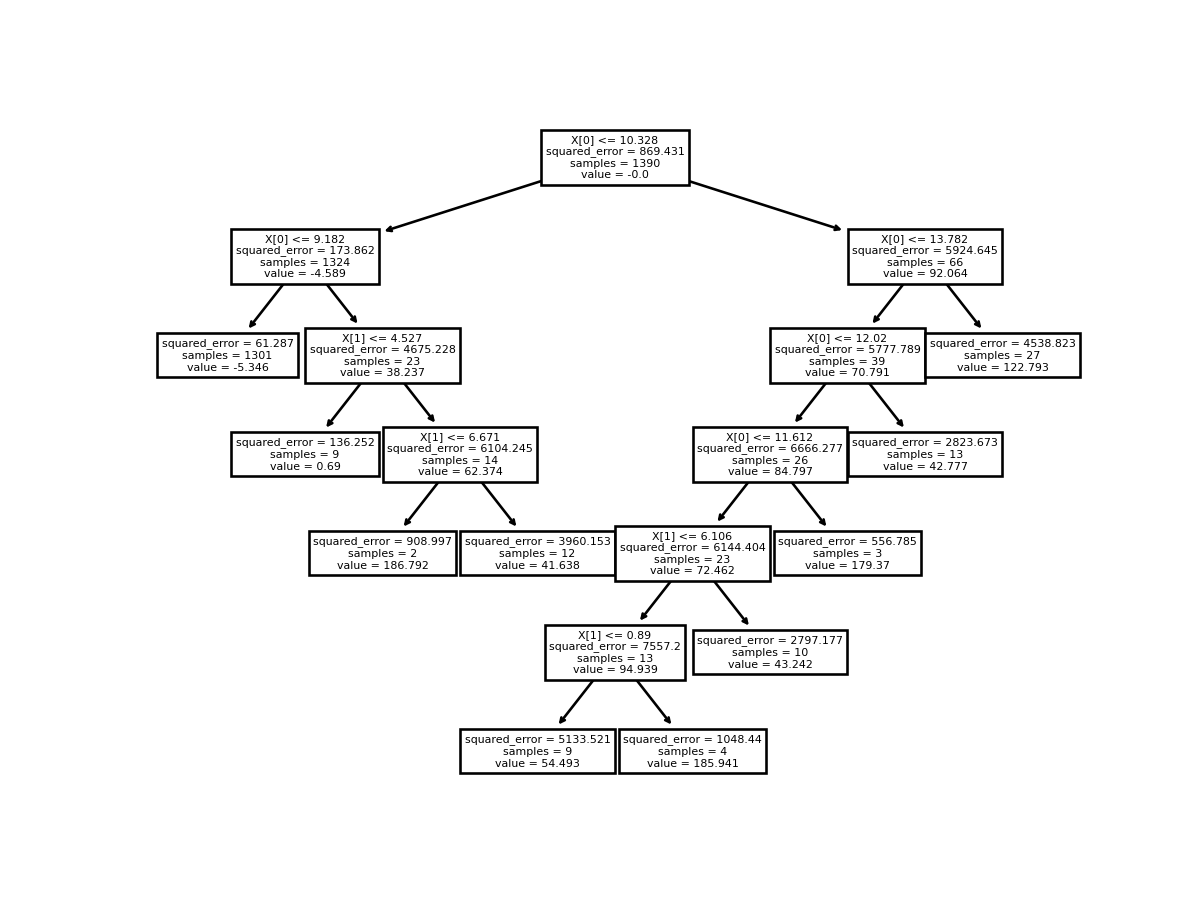

[Text(0.5, 0.9285714285714286, 'X[0] <= 10.328\nsquared_error = 869.431\nsamples = 1390\nvalue = -0.0'),
 Text(0.16666666666666666, 0.7857142857142857, 'X[0] <= 9.182\nsquared_error = 173.862\nsamples = 1324\nvalue = -4.589'),
 Text(0.08333333333333333, 0.6428571428571429, 'squared_error = 61.287\nsamples = 1301\nvalue = -5.346'),
 Text(0.25, 0.6428571428571429, 'X[1] <= 4.527\nsquared_error = 4675.228\nsamples = 23\nvalue = 38.237'),
 Text(0.16666666666666666, 0.5, 'squared_error = 136.252\nsamples = 9\nvalue = 0.69'),
 Text(0.3333333333333333, 0.5, 'X[1] <= 6.671\nsquared_error = 6104.245\nsamples = 14\nvalue = 62.374'),
 Text(0.25, 0.35714285714285715, 'squared_error = 908.997\nsamples = 2\nvalue = 186.792'),
 Text(0.4166666666666667, 0.35714285714285715, 'squared_error = 3960.153\nsamples = 12\nvalue = 41.638'),
 Text(0.8333333333333334, 0.7857142857142857, 'X[0] <= 13.782\nsquared_error = 5924.645\nsamples = 66\nvalue = 92.064'),
 Text(0.75, 0.6428571428571429, 'X[0] <= 12.02\nsqu

In [12]:
plot_tree(tree)

## All together in one function

In [13]:
def compute_lambdas(lambdas_per_query):
    lambdas_per_query = lambdas_per_query.sort_values(['qid', 'last_prediction'], ascending=[True, False], kind='stable')
    lambdas_per_query['display_rank'] = lambdas_per_query.groupby('qid').cumcount()

    #TBD - How do generalize this to any metric?
    lambdas_per_query['discount'] = 1 / np.log2(2 + lambdas_per_query['display_rank'])
    lambdas_per_query['gain'] = (2**lambdas_per_query['grade'] - 1)

    # swaps dataframe holds each pair-wise swap computed (shrink columns for memory?)   
    # Optimization of swaps = lambdas_per_query.merge(lambdas_per_query, on='qid', how='outer')
    # to limit to just needed columns
    to_swap = lambdas_per_query[['qid', 'display_rank', 'grade', 'last_prediction', 'discount', 'gain']]
    #to_swap = lambdas_per_query
    swaps = to_swap.merge(to_swap, on='qid', how='outer')

    # delta - delta in DCG due to swap
    swaps['delta'] = np.abs((swaps['discount_x'] - swaps['discount_y']) * (swaps['gain_x'] - swaps['gain_y']))
    
    # rho - based on current model prediction delta
    swaps['rho'] = 1 / (1 + np.exp(swaps['last_prediction_x'] - swaps['last_prediction_y']))
    
    # If you want to be pure gradient boosting, weight reweights each models prediction
    # I haven't found this to matter in practice
    swaps['weight'] = swaps['rho'] * (1.0 - swaps['rho']) * swaps['delta']

    # Compute lambdas (the next model in ensemble's predictors) when grade_x > grade_y
    swaps['lambda'] = 0
    slice_x_better =swaps[swaps['grade_x'] > swaps['grade_y']]
    swaps.loc[swaps['grade_x'] > swaps['grade_y'], 'lambda'] = slice_x_better['delta'] * slice_x_better['rho']
    
    # accumulate lambdas and add back to model
    lambdas_x = swaps.groupby(['qid', 'display_rank_x'])['lambda'].sum().rename('lambda')
    lambdas_y = swaps.groupby(['qid', 'display_rank_y'])['lambda'].sum().rename('lambda')

    weights_x = swaps.groupby(['qid', 'display_rank_x'])['weight'].sum().rename('weight')
    weights_y = swaps.groupby(['qid', 'display_rank_y'])['weight'].sum().rename('weight')
    
    weights = weights_x + weights_y
    lambdas = lambdas_x - lambdas_y

    lambdas_per_query = lambdas_per_query.merge(lambdas, 
                                                left_on=['qid', 'display_rank'], 
                                                right_on=['qid', 'display_rank_x'], 
                                                how='left')
    lambdas_per_query = lambdas_per_query.merge(weights, 
                                                left_on=['qid', 'display_rank'], 
                                                right_on=['qid', 'display_rank_x'], 
                                                how='left')

    return lambdas_per_query

## Build an ensemble!

Now we complete the picture by building an ensemble one piece at a time.

In [14]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd


ensemble=[]
def lambda_mart_pure(judgments, rounds=20,
                     learning_rate=0.1, max_leaf_nodes=8):

    print(judgments.columns)

    lambdas_per_query = judgments.copy()
    lambdas_per_query['last_prediction'] = 0.0

    for i in range(0, rounds):
        print(f"round {i}")

        # ------------------
        #1. Build pair-wise predictors for this round
        lambdas_per_query = compute_lambdas(lambdas_per_query)

        # ------------------
        #2. Train a regression tree on this round's lambdas
        features = lambdas_per_query['features'].tolist()
        new_tree = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
        new_tree.fit(features, lambdas_per_query['lambda'])    

        # -------------------
        #4. Add to ensemble, recreate last prediction
        ensemble.append(new_tree)
        next_predictions = new_tree.predict(features)
        lambdas_per_query['last_prediction'] += (next_predictions * learning_rate) 
        
        print(lambdas_per_query.loc[0, ['grade', 'last_prediction']])
        
        print("Train DCGs")
        lambdas_per_query['discounted_gain'] = lambdas_per_query['gain'] * lambdas_per_query['discount'] 
        dcg = lambdas_per_query[lambdas_per_query['display_rank'] < 10].groupby('qid')['discounted_gain'].sum().mean()
        print("mean   ", dcg)
        print("----------")
        
        lambdas_per_query = lambdas_per_query.drop(['lambda', 'weight'], axis=1)
    return lambdas_per_query


lambdas_per_query = lambda_mart_pure(judgments=judgments, rounds=50, max_leaf_nodes=10, learning_rate=0.01)

Index(['uid', 'qid', 'keywords', 'docId', 'grade', 'features'], dtype='object')
round 0
grade                     4
last_prediction    1.793696
Name: 0, dtype: object
Train DCGs
mean    20.193092700772873
----------
round 1
grade                     4
last_prediction    1.993689
Name: 0, dtype: object
Train DCGs
mean    20.709013438589473
----------
round 2
grade                     4
last_prediction    2.373362
Name: 0, dtype: object
Train DCGs
mean    20.721024101347314
----------
round 3
grade                     4
last_prediction    2.571041
Name: 0, dtype: object
Train DCGs
mean    20.732473007617937
----------
round 4
grade                     4
last_prediction    2.722381
Name: 0, dtype: object
Train DCGs
mean    20.665232520958057
----------
round 5
grade                     4
last_prediction    2.874663
Name: 0, dtype: object
Train DCGs
mean    20.738714381511848
----------
round 6
grade                     4
last_prediction    3.004437
Name: 0, dtype: object
Train DCGs
mean  

In [15]:
lambdas_per_query.head()

,uid,qid,keywords,docId,grade,features,last_prediction,display_rank,discount,gain,discounted_gain
0,17555,1,rambo,7555,4,"[11.657399, 10.083591]",4.630134,0,1.000000,15,15.000000
1,11370,1,rambo,1370,3,"[9.456276, 13.265001]",2.865759,1,0.630930,7,4.416508
2,11369,1,rambo,1369,3,"[6.036743, 11.113943]",2.498651,2,0.500000,7,3.500000
3,11368,1,rambo,1368,4,"[0.0, 11.113943]",1.886211,3,0.430677,15,6.460148
4,113258,1,rambo,13258,2,"[0.0, 6.8695450000000005]",-0.276126,4,0.386853,3,1.160558
